In [2]:
"""형태소 분석 후 json 형태의 파일로 저장된 파일을 이용해 최종 데이터 생성"""
import re
import ujson
import numpy as np; np.random.seed(1234)
import pandas as pd

POS_KEY = "lyric_pos"
LABEL_KEY = "genre"

def read_documents_with_labels(input_file_name):
    """주어진 이름을 파일에서 문서와 레이블들을 읽어서 돌려준다."""
    
    documents = ["lyric_pos"]
    labels = ["genre"]

    with open(input_file_name, "r", encoding="utf-8") as input_file:
        for line in input_file:
            morphs = []
            json_obj = ujson.loads(line)
            label = json_obj[LABEL_KEY]
            labels.append(label)

            for sent_anal in json_obj[POS_KEY]:
                for word, pos in sent_anal:
                    morphs.append(word)

            document = " ".join(morphs)
            documents.append(document)

    return documents, labels

    
def main():
    """형태소 분석 후 json 형태의 파일로 저장된 파일을 이용해 최종 데이터 생성"""
    
    input_file_name = r"/Users/baekseoin/Desktop/19_1학기/텍스트 분석기법/프로젝트/data/lyrics_pos.txt"
    output_file_name = r"/Users/baekseoin/Desktop/19_1학기/텍스트 분석기법/프로젝트/data/lyrics_pos_1.tsv"

    documents, labels = read_documents_with_labels(input_file_name)
    
    with open(output_file_name, "w", encoding="utf-8") as output_file:
            
        for document, label in zip(documents, labels): 
            outputs = [document, str(label)]
            print("\t".join(outputs), file=output_file)
                    
#
main()

In [3]:
# 데이터 파일 불러오기

import pandas as pd

DATA_FILE=r"/Users/baekseoin/Desktop/19_1학기/텍스트 분석기법/프로젝트/data/lyrics_pos_1.tsv"

data_file = pd.read_csv(DATA_FILE, delimiter = "\t")

list_sentences = data_file["lyric_pos"]

comments = []

for line in list_sentences:
    line = str(line)
    comments.append(line)

y = data_file["genre"]

print(len(comments))

9238


In [4]:
# Tokenizer() 함수 이용해 띄어쓰기 기준으로 단어 토큰화

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

MAX_NB_WORDS = 4340

tokenizer = Tokenizer(num_words=MAX_NB_WORDS
                      ,filters='!"#$%()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
                      ,lower=False)

tokenizer.fit_on_texts(comments)

# texts_to_sequences() 함수 이용해 단어를 숫자로 변환 

sequences = tokenizer.texts_to_sequences(comments)

# 문장을 토큰화 하여 단어의 index 생성 (word_index 구성: key= word, value = word의 고유번호)

MAX_SEQUENCE_LENGTH = 140

word_index = tokenizer.word_index
print('Found %s unique tokens' % len(word_index))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', y.shape)



Using TensorFlow backend.


Found 37460 unique tokens
Shape of data tensor: (9238, 140)
Shape of label tensor: (9238,)


In [5]:
# 워드 임베딩 모델의 결과 파일 불러오기 

from gensim.models.keyedvectors import KeyedVectors
import numpy as np

print('Preparing word embedding matrix')

EMBEDDING_DIM = 300

EMBEDDING_FILE = "/Users/baekseoin/Desktop/19_1학기/텍스트 분석기법/프로젝트/skipgram_300feaures_3window_5count_lyric"

word_vectors = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=False)

# prepare embedding matrix
nb_words = len(word_index)

#embedding_matrix = np.random.uniform(-1, 1, (nb_words, EMBEDDING_DIM))
embedding_matrix = np.zeros((nb_words, EMBEDDING_DIM))

for word, i in word_index.items():
    if i+1 > MAX_NB_WORDS:
        continue
        
    if word in word_vectors:
        embedding_vector = word_vectors[word]
        embedding_matrix[i] = embedding_vector
        
print('Null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))



Preparing word embedding matrix
Null word embeddings: 33123


In [6]:
# 훈련용 데이터와 검증용 데이터 나누기

VALIDATION_SPLIT = 0.3

np.random.seed(1234)

perm = np.random.permutation(len(data))
idx_train = perm[:int(len(data)*(1-VALIDATION_SPLIT))]
idx_test = perm[int(len(data)*(1-VALIDATION_SPLIT)):]

train_data=data[idx_train]
test_data=data[idx_test]

train_y=y[idx_train]
test_y=y[idx_test]

print(train_data.shape, test_data.shape, train_y.shape, test_y.shape)



(6466, 140) (2772, 140) (6466,) (2772,)


In [7]:
"""CNN 모델 구축 및 훈련"""

import os
import re
import csv
import codecs

from keras.models import Sequential
from keras.layers.convolutional import Convolution1D, Convolution2D
from keras.layers.convolutional import MaxPooling1D, MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.preprocessing import sequence
from keras.optimizers import *
from keras.regularizers import l2
from keras.layers.merge import concatenate
from keras.layers import Dropout



In [8]:
# 성과 지표 추가 

from keras import backend as K
from keras import metrics


def mcor(y_true, y_pred):
    # matthews_correlation
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos

    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos

    tp = K.sum(y_pos * y_pred_pos)
    tn = K.sum(y_neg * y_pred_neg)

    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)

    numerator = (tp * tn - fp * fn)
    denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

    return numerator / (denominator + K.epsilon())


def precision(y_true, y_pred):
    """Precision metric.

    Only computes a batch-wise average of precision.

    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    """Recall metric.

    Only computes a batch-wise average of recall.

    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall))



In [9]:
# 워드 임베딩 레이어 생성 

from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.models import Model, Sequential

embedding_layer = Embedding(nb_words, EMBEDDING_DIM, weights=[embedding_matrix],  
                            input_length=MAX_SEQUENCE_LENGTH, trainable=True)

# 입력 레이어 생성 

input_layer = Input(shape=(MAX_SEQUENCE_LENGTH,))
embedding = embedding_layer(input_layer)

# CNN 모델 생성 

conv = Convolution1D(filters=100, kernel_size=5, activation='relu', border_mode="same")(embedding)
drop = Dropout(0.5)(conv)
pool = MaxPooling1D(pool_size=2)(drop)

flat = Flatten()(pool)
dense = Dense(100, activation='relu')(flat)
CNN_MODEL = Dense(6, activation='softmax')(dense)



Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(filters=100, kernel_size=5, activation="relu", padding="same")`
  app.launch_new_instance()


In [10]:
# CNN 모델 훈련

cnn_model = Model(inputs=[input_layer], outputs=CNN_MODEL)

cnn_model.compile(loss='sparse_categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy', recall, precision, f1])

print (cnn_model.summary())

hist = cnn_model.fit(train_data, train_y, epochs=3, batch_size=64, shuffle=True)



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 140)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 140, 300)          11238000  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 140, 100)          150100    
_________________________________________________________________
dropout_1 (Dropout)          (None, 140, 100)          0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 70, 100)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 7000)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               700100    
__________

In [11]:
# CNN 모델 검증

loss_and_metrics = cnn_model.evaluate(test_data, test_y, batch_size = 64)

print('accuracy: ' + str(loss_and_metrics[1]))
print('recall: ' + str(loss_and_metrics[2]))
print('precision: ' + str(loss_and_metrics[3]))
print('f1: ' + str(loss_and_metrics[4]))




2772/2772 [==============================] - 3s 910us/step
accuracy: 0.3603896103036008
recall: 1.774504390457836
precision: 2.8064488745354987
f1: 2.16103680962952


In [12]:
from keras.utils import np_utils
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Activation
import numpy as np
from numpy import argmax

import pandas as pd


#print(test_data)
pred_y = cnn_model.predict(test_data)
pred_y2 = np.argmax(pred_y,axis=1)


A = pd.crosstab(test_y, pred_y2, rownames=['True'], colnames=['Predicted'], margins=False)
A.columns
A.index = ["발라드","댄스","힙합","트로트","락","일렉트로닉"]
A.index.name = '실제값'
A.columns = ["발라드","댄스","힙합","트로트","락","일렉트로닉"]
A.columns.name = '예측값'
A

예측값,발라드,댄스,힙합,트로트,락,일렉트로닉
실제값,,,,,,
발라드,12,7,22,1,189,255
댄스,4,20,46,2,57,332
힙합,0,3,198,0,42,195
트로트,2,0,6,246,105,70
락,4,4,15,9,184,258
일렉트로닉,2,4,53,2,84,339


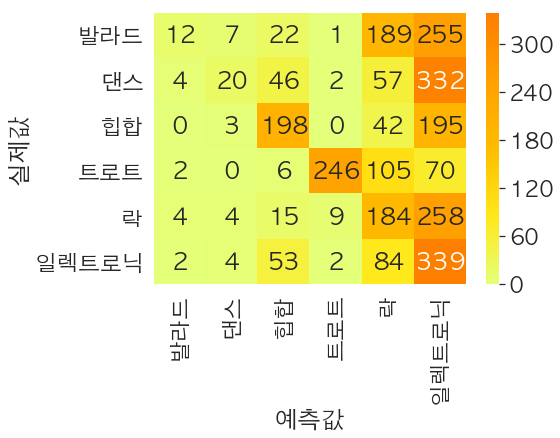

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rc
import seaborn as sns
%matplotlib inline
sns.set(font_scale=2)
rc('font', family='AppleGothic')

plt.rcParams['axes.unicode_minus'] = False

A.index=['발라드','댄스','힙합','트로트','락','일렉트로닉']
#result.columns=['ballad','dance','hiphop','trot','rock','electronic']
A.columns=['발라드','댄스','힙합','트로트','락','일렉트로닉']
A.index.name="실제값"
A.columns.name="예측값"

plt.figure(figsize=(7,5))
sns.heatmap(A, annot=True, cmap="Wistia", fmt="d")